In [45]:
import numpy as np
import pandas as pd
import seaborn as sns
import altair as alt
import re
import json
import os
from pathlib import Path 
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [2]:
def time_norm(data, time_n=np.linspace(0,100,101), axis=-1):
    own_time = np.linspace(time_n[0], time_n[-1], data.shape[0])
    a=data
    if np.isnan(a).any() and not(np.isnan(a).all()):
        first_non_nan = np.where(~np.isnan(a))[0][0]
        last_non_nan = np.where(~np.isnan(a))[0][-1]
        a_red=a[first_non_nan: last_non_nan+1]
        
        ratio_first = int(np.ceil(first_non_nan/len(a)*len(time_n)))
        ratio_last = int(np.floor(last_non_nan/len(a)*len(time_n)))
#         print(len())\n",
        a_red = fill_nan(a_red)
        f = interp1d(np.round(own_time[first_non_nan:last_non_nan+1],2), a_red, axis=axis, kind='cubic')
        try:
            y_red = f(time_n[ratio_first:ratio_last])
        except:
#             try:\n",
            print(f'Original x: {own_time[first_non_nan]} to {own_time[last_non_nan]} ')
            print(f'New x: {time_n[ratio_first]} to {time_n[ratio_last]} ')
            try:
                ratio_first +=1
                y_red = f(time_n[ratio_first:ratio_last])
            except:
                ratio_first +=1
                y_red = f(time_n[ratio_first:ratio_last])
        y = np.empty(len(time_n))
        y[:] = np.nan
        y[ratio_first:ratio_last]=y_red
#         plt.plot(own_time,a)
#         plt.plot(own_time[first_non_nan:last_non_nan+1], a_red)
#         plt.figure()
#         plt.plot(time_n, y)
    else:
        f = interp1d(own_time, a, axis=axis, kind='cubic')
        y = f(time_n)
    return y

In [3]:
PROJECT_PATH = Path("D:/Knee_Flexion_auditory_tactile_feedback/Analysis/results")
conf = pd.read_csv(PROJECT_PATH / '_conf.csv')
conf = conf[conf.process==1]
conf

,participant,age,height,mass,sex,leg,feedback_group,conf_file,process
0,P0,30,167,61,1,L,T,D:\Knee_Flexion_auditory_tactile_feedback\Anal...,1
1,N0,30,167,61,1,L,T,D:\Knee_Flexion_auditory_tactile_feedback\Anal...,1


Either P0 or their events do not exist


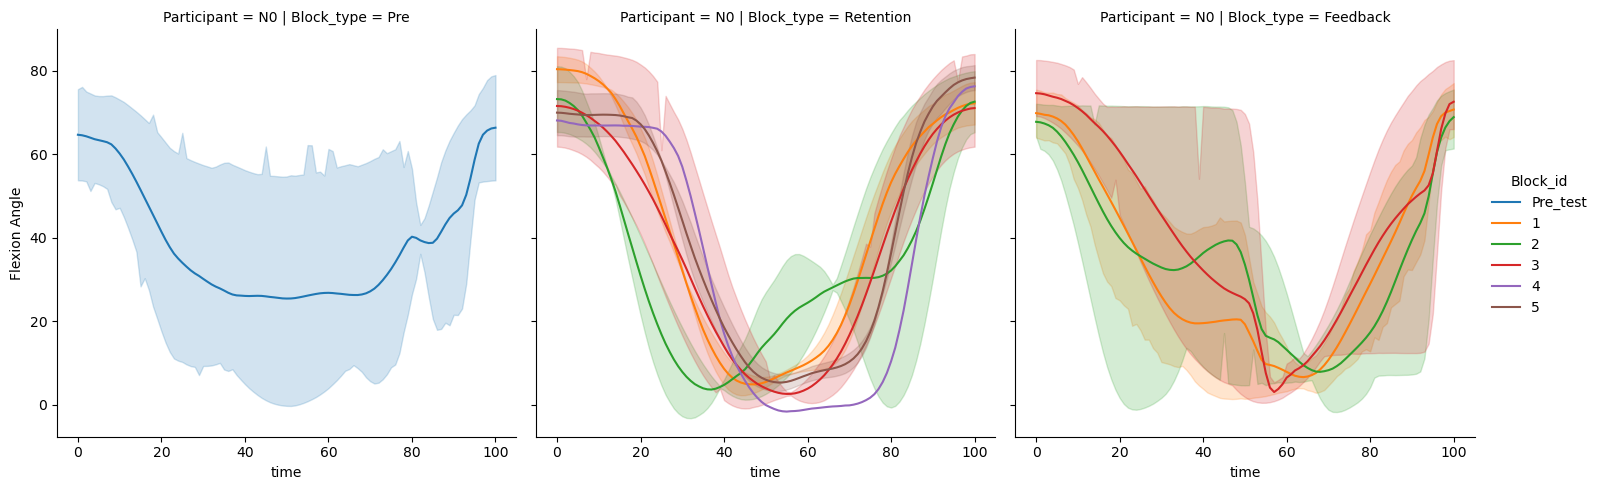

In [77]:
flexion_cycles = pd.DataFrame({'time' : np.linspace(0, 100, 101)})
for iparticipant in conf.participant[:]:
    lat = (conf[conf.participant == iparticipant]["leg"].values[0]).lower()
    try:
        json_path = str(PROJECT_PATH / iparticipant / "_conf.json")
        with open(json_path, 'r') as f:
            events = json.load(f)['events']
    except:
        print(f'Either {iparticipant} or their events do not exist')
        continue
    for itrial in events.keys():
        mot_event = events[itrial]
        event_frames = list(mot_event.values())
        mot_file = pd.read_csv(PROJECT_PATH / iparticipant / f"1_inverse_kinematic/{itrial}.mot", header=8, sep='\t')
        knee = mot_file[f'knee_angle_{lat}'].values
        for i, ievent in enumerate(event_frames):
            if i!= len(event_frames)-1:
                flexions = knee[ievent : event_frames[i+1]]
            else:
                flexions = knee[ievent: ]
            peaks, properties = find_peaks(flexions, prominence = (50, 100))
            for ipeak, peak in enumerate(peaks[:-1]):
                one_flexion = flexions[peak:peaks[ipeak+1]] 
                new_column_name = iparticipant + '_' + itrial + '_' + str(list(mot_event.keys())[i]) + '_' + str(ipeak)
                d = 90 + time_norm(one_flexion) # move from opensim angle to experimental definition
                flexion_cycles = flexion_cycles.join(pd.DataFrame({new_column_name : d}))
flexion_cycles.head() 

df = flexion_cycles.melt('time', value_name='Flexion Angle')
df['Participant'] = [i.split('_')[0] for i in df.variable]
df['n_flexion'] = [i.split('_')[-1] for i in df.variable]
df['Block_name'] = [i[15:-2] for i in df.variable]
df['Block_type'] = [i.split('_')[0] for i in df.Block_name]
df['Block_id'] = [[s for s in i if s.isdigit()][0] if [s for s in i if s.isdigit()] else 'Pre_test' for i in df.Block_name]

df.head()
sns.relplot(df, x='time', y='Flexion Angle', row='Participant', hue='Block_id', kind='line', col='Block_type')


<Axes: xlabel='time', ylabel='Flexion Angle'>

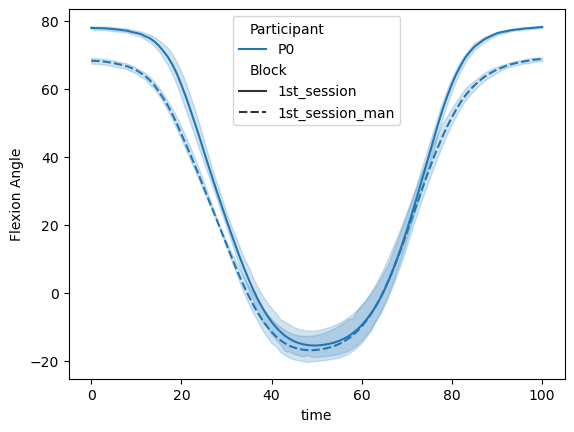

In [84]:
#     mot = [ifile for ifile in (PROJECT_PATH / iparticipant / "1_inverse_kinematic").glob("*.mot") if 'session' in ifile.stem]
#     for imot in mot:
#         ik = pd.read_csv(imot, header=8, sep='\t')
#         knee = ik[f'knee_angle_{lat}'].values
#         peaks, properties = find_peaks(knee, prominence = (50, 100))
#         for ipeak, peak in enumerate(peaks[:-1]):
#             one_flexion = knee[peak:peaks[ipeak+1]] 
#             new_column_name = iparticipant + '_' + imot.stem + '_' + str(ipeak)
#             d = 90 + time_norm(one_flexion) # move from opensim angle to experimental definition
#             flexion_cycles = flexion_cycles.join(pd.DataFrame({new_column_name : d}))
            

# df = flexion_cycles.melt('time', value_name='Flexion Angle')
# df['Participant'] = [i.split('_')[0] for i in df.variable]
# df['n_flexion'] = [i.split('_')[-1] for i in df.variable]
# df['Block'] = [i[3:-2] for i in df.variable]
# df.head()
# sns.lineplot(df, x='time', y='Flexion Angle', hue='Participant', style='Block')

In [ ]:
loc